# Example of using early stopping

Here, we use early stopping in training the Simple Graph Convolution on Cora dataset. The code is adapted from 

In [66]:
# Import packages
import dgl
from dgl.data import CoraGraphDataset
from dgl.nn.pytorch.conv import SGConv
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

In [67]:
# Defined functions for training purpose

# Loss function
def loss_fnc(labels, outputs, masks = None):
    # Loss
    loss_fnc = nn.CrossEntropyLoss()

    # Compute the loss
    if masks is not None:
        loss = loss_fnc(outputs[masks], labels[masks])
    else: 
        loss = loss_fnc(outputs, labels)
    
    return loss

# Evaluation function 
def evaluate(model, loss_fn, g, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)[mask]
        
        labels = labels[mask]
        
        # compute loss
        loss = loss_fn(labels, logits)
        
        # compute acc
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        acc = correct.item() * 1.0 / len(labels)
        return loss.item(), acc
        
# Trainer wrapper function
def make_trainer(model, loss_fn, optimizer):
    def trainer(features, labels, g, mask):
        # Sets model to TRAIN mode
        model.train()
       
        # Makes predictions
        logits = model(g, features)
              
        # Compute the loss
        loss = loss_fn(labels, logits, masks = mask)
        
        # Computes gradients
        loss.backward()
        
        # Updates parameters and zeroes gradientss
        optimizer.step()
        optimizer.zero_grad()
        
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return trainer

In [68]:
# Load dataset
data = CoraGraphDataset()

g = data[0]
   
features = g.ndata['feat']
labels = g.ndata['label']
train_mask = g.ndata['train_mask'].to(torch.bool)
val_mask = g.ndata['val_mask'].to(torch.bool)
test_mask = g.ndata['test_mask'].to(torch.bool)
in_feats = features.shape[1]
n_classes = torch.unique(labels).numel()
n_edges = g.number_of_edges()

# add self loop
g = dgl.remove_self_loop(g)
g = dgl.add_self_loop(g)


  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [69]:
# Hyper parameters
num_k = 2
lr_rate = 0.2
weight_decay = 0
seed = 10

def model_opt(num_k, lr_rate, weight_decay, seed):
    # Set seed
    torch.manual_seed(seed)
    # SGC model
    model = SGConv(in_feats,
                    n_classes,
                    k=num_k,
                    cached=True,
                    bias=False)

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(),
                                    lr=lr_rate,
                                    weight_decay= weight_decay)
    
    return model,optimizer

## Training the SGC without early stopping

First, let see how the model performs without using early stopping to avoid overfitting. For this example, we will set the number of training epochs as 300. As the training proceeds, the model gradually learns the underlying relationship and we observe both the training loss and validation loss decrease rapidly. However, after about 100 iterations, the validation loss starts to increase indicating the occurence of overfitting  

In [70]:
# Training parameters
num_epochs = 300

In [71]:
model, optimizer = model_opt(num_k, lr_rate, weight_decay,seed)

# Create trainer
train_model = make_trainer(model, loss_fnc, optimizer)

dur = []

t0 = time.time()

tr_loss_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    
    loss = train_model(features,labels,g,train_mask)

    dur.append(time.time() - t0)

    val_loss, val_acc = evaluate(model, loss_fnc, g, features, labels, val_mask)
    
    tr_loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    if (epoch + 1) % 50 == 0:
        print("Epoch {:05d} | Time(s) {:.4f} | Training Loss {:.4f} | Validation Loss {:.4f} | "
            .format(epoch + 1, np.mean(dur), loss, val_loss))
    
_,acc = evaluate(model, loss_fnc, g, features, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))


Epoch 00050 | Time(s) 0.2268 | Training Loss 0.0809 | Validation Loss 0.8108 | 
Epoch 00100 | Time(s) 0.3871 | Training Loss 0.0300 | Validation Loss 0.7929 | 
Epoch 00150 | Time(s) 0.5630 | Training Loss 0.0174 | Validation Loss 0.7999 | 
Epoch 00200 | Time(s) 0.7339 | Training Loss 0.0117 | Validation Loss 0.8104 | 
Epoch 00250 | Time(s) 0.9132 | Training Loss 0.0085 | Validation Loss 0.8214 | 
Epoch 00300 | Time(s) 1.0879 | Training Loss 0.0065 | Validation Loss 0.8322 | 
Test Accuracy 0.7610


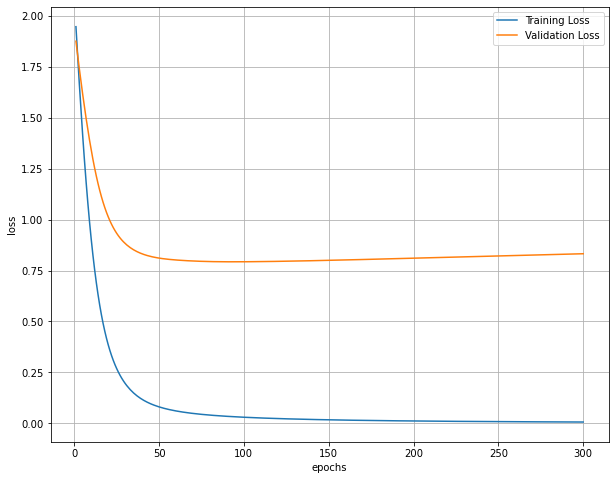

In [72]:
# Visualization
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, num_epochs + 1),tr_loss_list, label='Training Loss')
plt.plot(range(1, num_epochs + 1),val_loss_list,label='Validation Loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

## Training the SGC with early stopping

Next, we will apply early stopping for training the SGC. First, we will use *validation loss* to monitor the training process. We set the patience as 20 epochs. Now, we see that the best model is obtained at epoch 93. With the use of early stopping, we avoid overfitting and the model achieves better performance on test data

In [73]:
# Import early stopping class
from utils import EarlyStopping

# Checkpoint path
checkpoints_path=f'./cora_sgc+k_{num_k}.pt'

# Patience
num_patience = 20

# Delta 
delta_pct = 0

## Create dict of metric and direction
metric_direction = {
    'loss':'low'
}

# Create early stopping object
stopper = EarlyStopping(checkpoints_path, patience = num_patience, verbose= False, delta = delta_pct, **metric_direction)

Selected metric for early stopping: {'loss': 'low'}


In [74]:
# Training with stopper
model, optimizer = model_opt(num_k, lr_rate, weight_decay,seed)

# Create trainer
train_model = make_trainer(model, loss_fnc, optimizer)

dur = []

t0 = time.time()

for epoch in range(num_epochs):
    
    loss = train_model(features,labels,g,train_mask)

    dur.append(time.time() - t0)

    val_loss,_ = evaluate(model, loss_fnc, g, features, labels, val_mask)

    if (epoch + 1) % 50 == 0:
        print("Epoch {:05d} | Time(s) {:.4f} | Training Loss {:.4f} | Validation Loss {:.4f} | "
            .format(epoch + 1, np.mean(dur), loss, val_loss))
    
    # Set dictionary metric_value for stopper 
    metric_value = {
        'loss': val_loss
    }
    
    if stopper(model, epoch, **metric_value):
        print(f'Best model achieved at epoch: {stopper.best_epoch + 1}')
        break
        
print()
    
print('Loading model before testing.')
model_checkpoint = torch.load(checkpoints_path,
                                map_location=lambda storage, loc: storage)
model.load_state_dict(model_checkpoint['state_dict'])

_,acc = evaluate(model, loss_fnc, g, features, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))

Epoch 00050 | Time(s) 0.2501 | Training Loss 0.0809 | Validation Loss 0.8108 | 
Epoch 00100 | Time(s) 0.4470 | Training Loss 0.0300 | Validation Loss 0.7929 | 
Best model achieved at epoch: 93

Loading model before testing.
Test Accuracy 0.7700


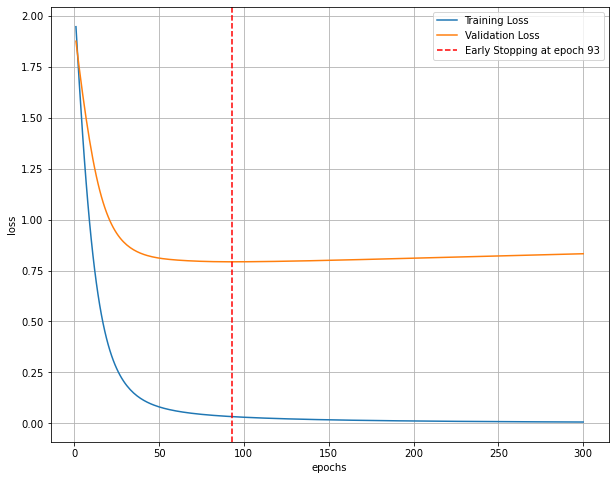

In [75]:
# Visualization
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, num_epochs + 1),tr_loss_list, label='Training Loss')
plt.plot(range(1, num_epochs + 1),val_loss_list,label='Validation Loss')

# Find position of lowest validation loss
min_val_loss_id = val_loss_list.index(min(val_loss_list))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping at epoch '+str(min_val_loss_id))

plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

### Using early stopping with validation accuracy

We can also use *validation accuracy* as our metric for stooper object. Now, the best model is obtained at epoch 21 and the performance on test data is further improved

In [76]:
## Create dict of metric and direction
metric_direction = {
    'acc':'high'
}

# Create early stopping object
stopper = EarlyStopping(checkpoints_path, patience = num_patience, verbose= False, delta = 0, **metric_direction)

Selected metric for early stopping: {'acc': 'high'}


In [77]:
# Training with stopper
model, optimizer = model_opt(num_k, lr_rate, weight_decay,seed)

# Create trainer
train_model = make_trainer(model, loss_fnc, optimizer)

dur = []

t0 = time.time()

for epoch in range(num_epochs):
    
    loss = train_model(features,labels,g,train_mask)

    dur.append(time.time() - t0)

    val_loss,val_acc = evaluate(model, loss_fnc, g, features, labels, val_mask)

    if (epoch + 1) % 50 == 0:
        print("Epoch {:05d} | Time(s) {:.4f} | Training Loss {:.4f} | Validation Loss {:.4f} | Validation Acc {:.4f} "
            .format(epoch + 1, np.mean(dur), loss, val_loss, val_acc))
    
    # Set dictionary metric_value for stopper 
    metric_value = {
        'acc': val_acc
    }
    
    if stopper(model, epoch, **metric_value):
        print(f'Best model achieved at epoch: {stopper.best_epoch + 1}')
        break
        
print()
    
print('Loading model before testing.')
model_checkpoint = torch.load(checkpoints_path,
                                map_location=lambda storage, loc: storage)
model.load_state_dict(model_checkpoint['state_dict'])

_,acc = evaluate(model, loss_fnc, g, features, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))

Best model achieved at epoch: 21

Loading model before testing.
Test Accuracy 0.7900


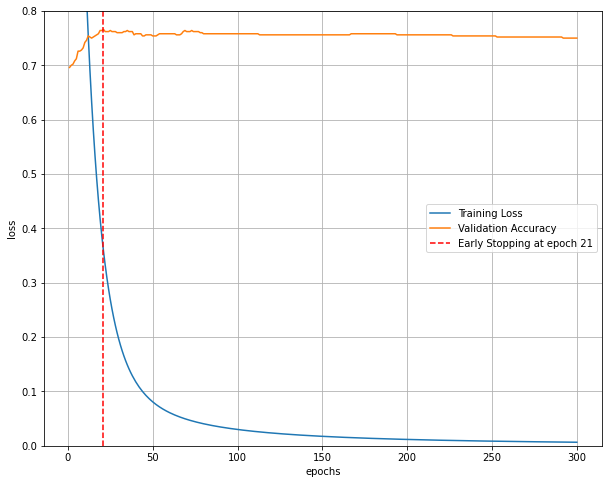

In [82]:
# Visualization
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, num_epochs + 1),tr_loss_list, label='Training Loss')
plt.plot(range(1, num_epochs + 1),val_acc_list,label='Validation Accuracy')

# Find position of lowest validation loss
max_val_acc_id = val_acc_list.index(max(val_acc_list))+1 
plt.axvline(max_val_acc_id, linestyle='--', color='r',label='Early Stopping at epoch '+str(max_val_acc_id))

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.8)
plt.grid(True)
plt.legend()
plt.show()